## Time Series Analysis using Sweet Life Taxi data 

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import numpy as np
import pandas as pd
#for graphs
import matplotlib.pyplot as plt

#import named models 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima


#import ability to split into training and testing data sets 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

#import ability to evaluate accuracy of data 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#needed to compare. 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.utils import check_X_y

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.preprocessing import OrdinalEncoder

from IPython.display import display



In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20


In [3]:
# convert datetime column to american readability
#df['datetime'] =pd.to_datetime(df['datetime'] ,format='%y-%m-%d %H:%M',errors='coerce')
#convert datetime datatype 
df['datetime'] = pd.to_datetime(df['datetime'])


In [4]:
#check if any rows are duplicated
df.duplicated().sum()

0

In [5]:
#check for empty cells.from info printout does not seem there is any but confirm 
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

## Analysis

             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
AxesSubplot(0.125,0.11;0.775x0.77)


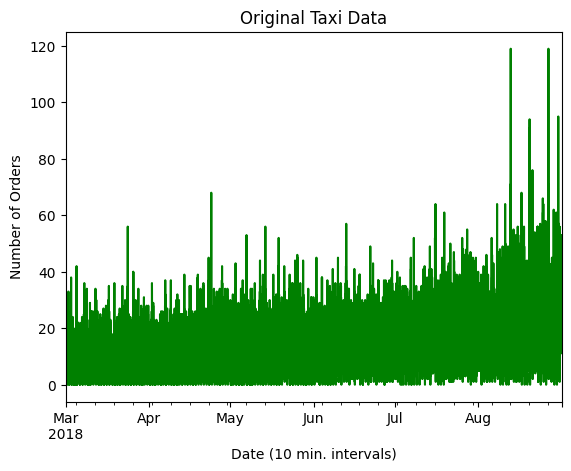

In [6]:
# Set the datetime column as the index
print(df.head(3))
df = df.set_index('datetime')
#resample into hour groupings rather than 10 minutes 
print(df.plot(xlabel='Date (10 min. intervals)', ylabel='Number of Orders',title='Original Taxi Data', color='green', legend=False))


                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
AxesSubplot(0.125,0.11;0.775x0.77)


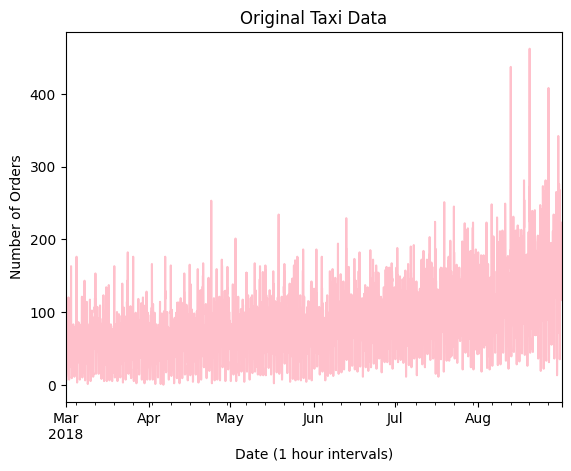

In [7]:
dfs=df.resample('1H').sum()
print(dfs.head(4))
print(dfs.plot(xlabel='Date (1 hour intervals)', ylabel='Number of Orders',title='Original Taxi Data', color='pink', legend=False))

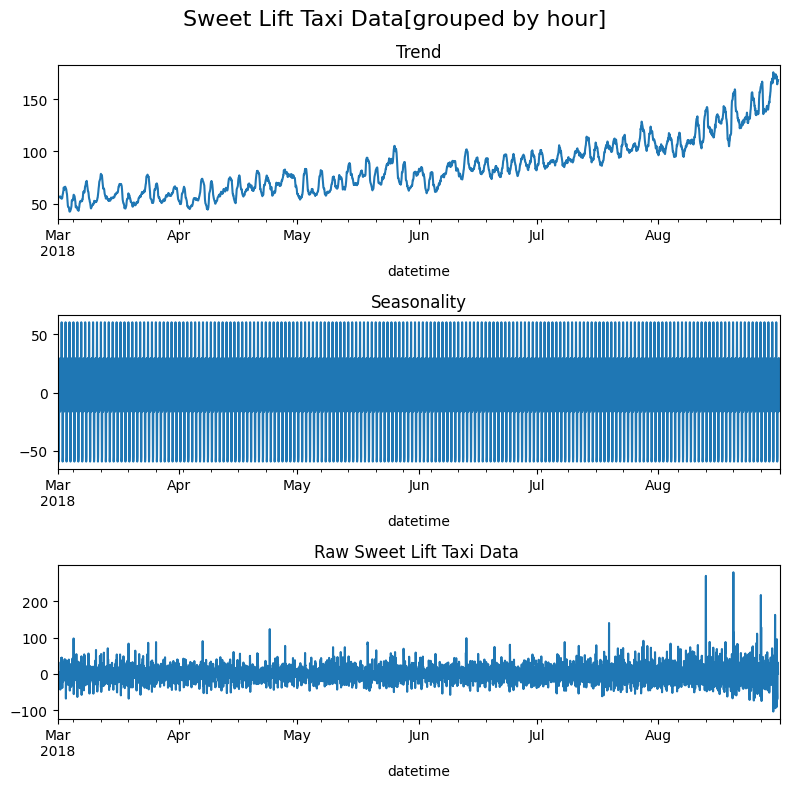

In [8]:
#evaluate summed data frame dfs for any trend, seasonality, or residual
decomposed = seasonal_decompose(dfs)

plt.figure(figsize=(8, 8))
plt.suptitle('Sweet Lift Taxi Data[grouped by hour]', fontsize=16)  # Add title to the figure

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.title('Raw Sweet Lift Taxi Data ')

plt.tight_layout()  

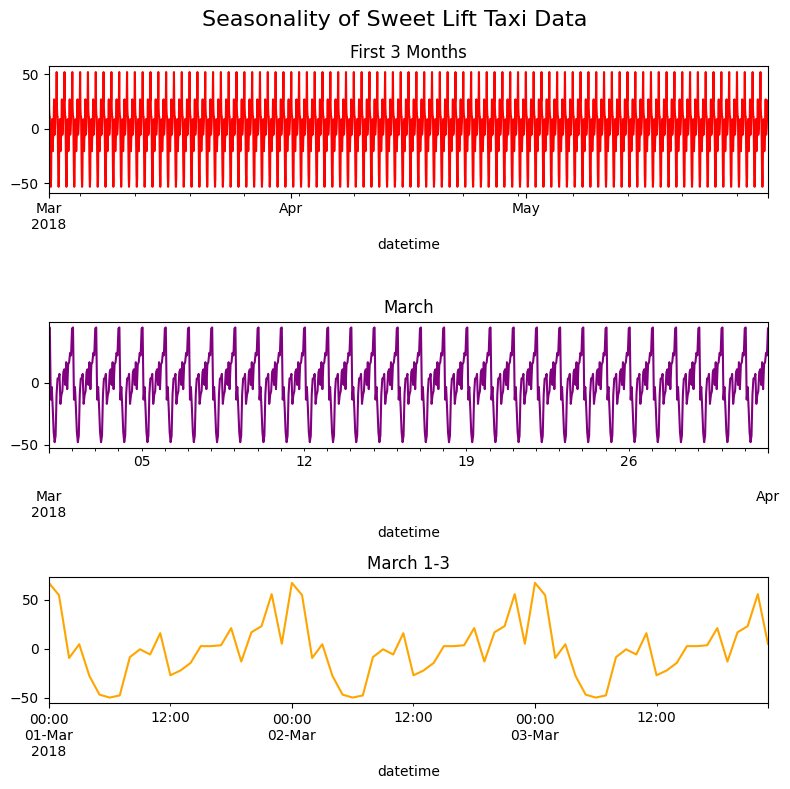

In [9]:
#evaluate a smaller time frame to detect if any seasonality trends. choose the first three months (March/April/May)
#cut dataframe in half
three_month=dfs.iloc[:2208]
three_season = seasonal_decompose(three_month)

#cut dataframe to be just march
march=three_month.iloc[:745]
month_season = seasonal_decompose(march)

#cut dataframe the be first 3 days of march since seasonality pattern repeat
days=march.iloc[:72]
day_season = seasonal_decompose(days)


plt.figure(figsize=(8, 8))
plt.suptitle('Seasonality of Sweet Lift Taxi Data', fontsize=16)  # Add title to the figure

plt.subplot(311)
three_season.seasonal.plot(ax=plt.gca(),color='red')
plt.title('First 3 Months')
plt.subplot(312)
month_season.seasonal.plot(ax=plt.gca(),color='purple')
plt.title('March')
plt.subplot(313)
day_season.seasonal.plot(ax=plt.gca(),color='orange')
plt.title('March 1-3')


plt.tight_layout() 


## EDA Conclusion 
The data did not require much manipulation.  There were no rows that were duplicated or empty.  The df['datetime'] column needed to switch from an object datatype to a datetime.  The original data points were taken every 10 minutes.  In the pink chart above the information was summed for every hour.  

A trend exists at the taxi company that the number of rides is increasing as time goes along. This is great news for business.  Evaluating with 'seasonal_decompose' there was an observable seasonality but an overload of data. The data was cut down until seasonality could be seen on graph.  At first just three months were looked at, then just the month of March, and then the first three days of March.  In the subplot for the first three days of March it is visible that every 24 hours the pattern repeats.  The call for taxis is the highest around midnight. Wherever Sweet Lift Taxi company airport must have an influx of flight arrivals near 11pm and midnight. Flights also must increase in the warmer months.   

## Training

In [10]:
def train_or_test(pipeline,x_train,y_train,x_test,y_test):
    pipeline.fit(x_train,y_train)
    y_pred=pipeline.predict(x_test)
    
    rmse=mean_square_error(y_test,y_pred,squared=False)
    
    return rmse

In [11]:
dfs.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [12]:
# Generate features from datetime index
dfs['hour'] = dfs.index.hour
dfs['day_of_week'] = dfs.index.dayofweek
dfs['is_weekend'] = dfs['day_of_week'].isin([5, 6]).astype(int)
dfs['rolling_mean'] = dfs['num_orders'].rolling(4).mean()
dfs['lag_1'] = dfs['num_orders'].shift(1)
dfs['lag_2'] = dfs['num_orders'].shift(2)
dfs['lag_3'] = dfs['num_orders'].shift(3)

# Define features (x) and target (y)
x = dfs.drop('num_orders', axis=1)
y = dfs['num_orders']

# Check the dataset before splitting
print("x shape:", x.shape)
display("x head:\n", x.head())
print("y shape:", y.shape)
display("y head:\n", y.head())


x shape: (4416, 7)


'x head:\n'

,hour,day_of_week,is_weekend,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,,,
2018-03-01 00:00:00,0,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,1,3,0,NaN,124.0,NaN,NaN
2018-03-01 02:00:00,2,3,0,NaN,85.0,124.0,NaN
2018-03-01 03:00:00,3,3,0,86.50,71.0,85.0,124.0
2018-03-01 04:00:00,4,3,0,66.25,66.0,71.0,85.0


y shape: (4416,)


'y head:\n'

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: int64

In [13]:
#check for new NAN in newly created features
dfs.isna().sum()
#NAN only exist for first 3 rows. will not effect overall results so drop those rows. 
dfs=dfs.dropna()

In [14]:
x=dfs.drop('num_orders',axis=1)
y=dfs['num_orders']

In [15]:
#split data for training and test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1, random_state=42,shuffle=False)

In [16]:
# Check that x_train and y_train are valid
x_train, y_train = check_X_y(x_train, y_train)

In [17]:
# Define the number of splits for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models and their respective parameter grids
models_and_params = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'random_state': [0, 42, 123]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'max_depth': [3, 5, 10],
            'random_state': [0, 42, 123]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            'random_state': [0, 42, 123]
        }
    }
}

# Loop through models and perform grid search
for model_name, config in models_and_params.items():
    print(f"Running GridSearchCV for {model_name}...")

    if config['param_grid']:
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        # Fit the model using GridSearchCV
        grid_search.fit(x_train, y_train)

        # Get the best model and make predictions
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(x_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, predictions))

        print(f"Best {model_name} Parameters: {grid_search.best_params_}")
    else:
        # For models without hyperparameters train directly
        model = config['model']
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"{model_name} RMSE: {rmse:.2f}")
    print("-" * 50)


Running GridSearchCV for RandomForest...
Best RandomForest Parameters: {'max_depth': 20, 'n_estimators': 200, 'random_state': 42}
RandomForest RMSE: 33.88
--------------------------------------------------
Running GridSearchCV for DecisionTree...
Best DecisionTree Parameters: {'max_depth': 10, 'random_state': 42}
DecisionTree RMSE: 43.50
--------------------------------------------------
Running GridSearchCV for GradientBoosting...
Best GradientBoosting Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'random_state': 123}
GradientBoosting RMSE: 27.54
--------------------------------------------------


## Testing

In [18]:
# Gradient Boosting Model
gbr = GradientBoostingRegressor(n_estimators=200,learning_rate=0.2,max_depth=3,random_state=123)
gbr.fit(x_train, y_train)
y_pred_gbr = gbr.predict(x_test)
# Calculate RMSE
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)

# Output results
print(f'Gradient Boosting (Scikit-learn) RMSE: {rmse_gbr}')


Gradient Boosting (Scikit-learn) RMSE: 27.541997638752466


## Conclusion 
GridSearchCV was able to provide the best hyperparameters for the different types of models being utilized.  Training set evaluated Random Forest, Decision Tree, Gradient Boosting, and LightGBM.  In analyzing performance on the test set the best model was Gradient Boosting with an RMSE of 27.54. Grdient Boosting was then run with the test set data.  The final RMSE was 27.54.  